In [1]:
from datetime import datetime
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.renderers.default = 'vscode' 

pd.set_option('display.max_columns', 500) # number of columns to be displayed
pd.set_option('display.width', 1500)      # max table width to display

if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
 
rates = mt5.copy_rates_from("PETR4", mt5.TIMEFRAME_H1, datetime(2025, 7, 4), 15000)
 
mt5.shutdown()
 
df = pd.DataFrame(rates)

df['time']=pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# display data
print("\nDisplay dataframe with data")
df.head(3)


Display dataframe with data


open  high   low  close  tick_volume  spread  real_volume
time                                                                          
2020-07-06 10:00:00  6.57  6.70  6.55   6.70        14424       1     20133300
2020-07-06 11:00:00  6.70  6.71  6.61   6.65        11449       1     13501600
2020-07-06 12:00:00  6.65  6.65  6.58   6.58         6188       1      4727900

## Cálculo do RSI

In [2]:
periods = 21
# variação de um fechamento para o outro
close_ret = df['close']/df['close'].shift(1)-1 
# substitui os negativos por zero
up = close_ret.clip(lower=0) 
# substitui os positivos por zero
down = -1*close_ret.clip(upper=0) 
# média dos dias de alta
ma_up = up.rolling(window=periods).mean()
# média dos dias de baixa
ma_down = down.rolling(window=periods).mean()
#indicador
rs = ma_up/ma_down
df['rsi'] = 100-(100/(1+rs))
df.tail(3)

open   high    low  close  tick_volume  spread  real_volume        rsi
time                                                                                        
2025-07-03 14:00:00  32.30  32.31  32.23  32.25         2632       1       936300  77.579562
2025-07-03 15:00:00  32.24  32.25  32.17  32.19         2591       1      1328600  74.451799
2025-07-03 16:00:00  32.20  32.22  32.15  32.16         3328       1      2898300  72.046326

In [3]:
fig = make_subplots(rows=2,cols=1,row_heights=[0.7,0.3],vertical_spacing=0.02,shared_xaxes=True)
fig.add_trace(go.Candlestick(x=df.index, open=df.open, high=df.high, low=df.low, close=df.close), row=1,col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['rsi']), row=2, col=1)
fig.update_xaxes(rangebreaks=[dict(bounds=[18,10], pattern='hour'),dict(bounds=['sat', 'mon'])])
fig.update_layout(height = 600, xaxis_rangeslider_visible=False)
fig.show()

## Estratégia: 
Comprar quando o RSI for que 30 e vender quando for maior que 70

In [4]:
def get_rsi(window):
    # variação de um fechamento para o outro
    close_ret = df['close']/df['close'].shift(1)-1 
    # substitui os negativos por zero
    up = close_ret.clip(lower=0) 
    # substitui os positivos por zero
    down = -1*close_ret.clip(upper=0) 
    # média dos dias de alta
    ma_up = up.rolling(window=window).mean()
    # média dos dias de baixa
    ma_down = down.rolling(window=window).mean()
    #indicador
    rs = ma_up/ma_down
    rsi = 100-(100/(1+rs))
    
    return rsi

In [5]:
window = 14
up_exit = 70
down_entry = 30
bet_size = 100

df['rsi'] = get_rsi(window)

list_trades = []
t = 0

for idx,row in df.iterrows():
    # se o rsi for menor que 30 e não tiver operações em aberto (t=0)
    if row['rsi'] <= down_entry and t == 0:
        list_trades += [{'time': idx, 'price':row['close'], 'kind':'buy', 'quantity': bet_size}]
        t = 1 # Agora está comprado/vendido
    
    # Se o rsi for maior que 70 e tiver operações em aberto (t+1)
    if row['rsi'] >= up_exit and t == 1:
        list_trades += [{'time': idx, 'price':row['close'], 'kind':'sell', 'quantity': -bet_size}]
        t = 0 # Agora não tem nenhuma operação

df_raw = pd.DataFrame(list_trades)
df_raw.set_index('time', inplace=True)
df_raw.head(3)

price  kind  quantity
time                                      
2020-07-17 15:00:00   6.64   buy       100
2020-07-22 10:00:00   6.84  sell      -100
2020-07-23 10:00:00   6.80   buy       100

In [6]:
df_buys = df_raw[df_raw['kind'] == 'buy']
df_sells = df_raw[df_raw['kind'] == 'sell']
fig = make_subplots(rows=2,cols=1,row_heights=[0.7,0.3],vertical_spacing=0.02,shared_xaxes=True)
fig.add_trace(go.Candlestick(x=df.index, open=df.open, high=df.high, low=df.low, close=df.close), row=1,col=1)
fig.add_trace(go.Scatter(x=df_buys.index, y=df_buys['price'], marker_color='green', marker_size=15, mode='markers', marker_symbol='triangle-up'),row=1,col=1)
fig.add_trace(go.Scatter(x=df_sells.index, y=df_sells['price'], marker_color='red', marker_size=15, mode='markers', marker_symbol='triangle-up'),row=1,col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['rsi']), row=2, col=1)
fig.update_xaxes(rangebreaks=[dict(bounds=[18,10], pattern='hour'),dict(bounds=['sat', 'mon'])])
fig.update_layout(height = 600, xaxis_rangeslider_visible=False)
fig.show()

## Curva de retornos

Como está o meu patrimônio ao longo do tempo?

In [7]:
df_trades = df_raw.join(df['close'], how='outer')
df_trades

price kind  quantity  close
time                                            
2020-07-06 10:00:00    NaN  NaN       NaN   6.70
2020-07-06 11:00:00    NaN  NaN       NaN   6.65
2020-07-06 12:00:00    NaN  NaN       NaN   6.58
2020-07-06 13:00:00    NaN  NaN       NaN   6.61
2020-07-06 14:00:00    NaN  NaN       NaN   6.62
...                    ...  ...       ...    ...
2025-07-03 12:00:00    NaN  NaN       NaN  32.24
2025-07-03 13:00:00    NaN  NaN       NaN  32.30
2025-07-03 14:00:00    NaN  NaN       NaN  32.25
2025-07-03 15:00:00    NaN  NaN       NaN  32.19
2025-07-03 16:00:00    NaN  NaN       NaN  32.16

[9161 rows x 4 columns]

In [8]:
df_trades[-df_trades['price'].isna()]

price  kind  quantity  close
time                                             
2020-07-17 15:00:00   6.64   buy     100.0   6.64
2020-07-22 10:00:00   6.84  sell    -100.0   6.84
2020-07-23 10:00:00   6.80   buy     100.0   6.80
2020-07-27 16:00:00   6.81  sell    -100.0   6.81
2020-07-31 12:00:00   6.60   buy     100.0   6.60
...                    ...   ...       ...    ...
2025-05-27 10:00:00  30.65  sell    -100.0  30.65
2025-05-30 10:00:00  30.30   buy     100.0  30.30
2025-06-11 10:00:00  30.60  sell    -100.0  30.60
2025-06-23 14:00:00  32.17   buy     100.0  32.17
2025-07-02 11:00:00  31.68  sell    -100.0  31.68

[230 rows x 4 columns]

## Atenção

Sem o shift(1) é como se o retorno anterior ao que eu comprei, fosse meu.

Comprei candle do dia 10, o retorno do dia 9 para o 10 não é meu, por isso tem que dar o shift

<Axes: xlabel='time'>

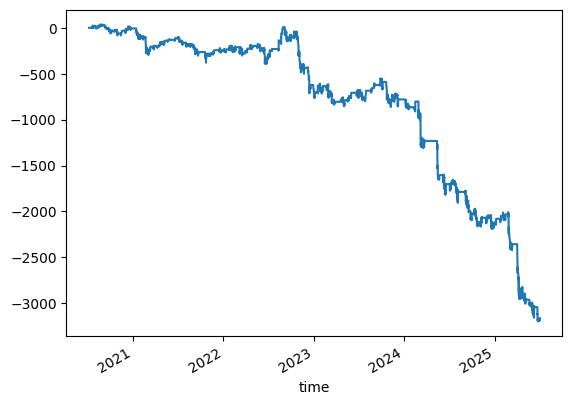

In [9]:
# O sistema atual compra e já conta como se tivesse rendido, mas isso não está correto
# Por isso tem que adicionar o shift
df_trades['position'] = df_trades['quantity'].fillna(0).cumsum()

df_trades['ret_market'] = df_trades['close'] - df_trades['close'].shift(1)
df_trades['ret'] = df_trades['ret_market'] * df_trades['position']
df_trades['ret_cum'] = df_trades['ret'].cumsum()
df_trades['ret_cum'].plot()

<Axes: xlabel='time'>

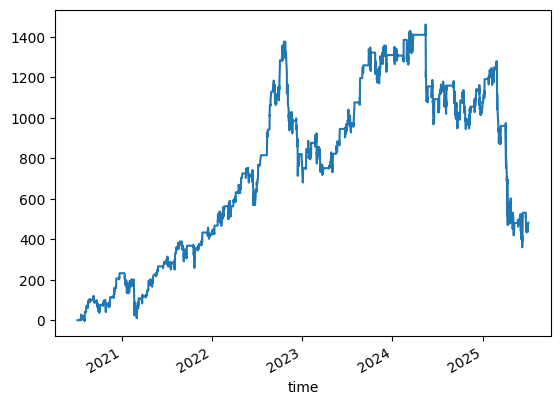

In [10]:
# O sistema atual compra e já conta como se tivesse rendido, mas isso não está correto
# Por isso tem que adicionar o shift
df_trades['position'] = df_trades['quantity'].shift(1).fillna(0).cumsum()

df_trades['ret_market'] = df_trades['close'] - df_trades['close'].shift(1)
df_trades['ret'] = df_trades['ret_market'] * df_trades['position']
df_trades['ret_cum'] = df_trades['ret'].cumsum()
df_trades['ret_cum'].plot()

In [11]:
# Testando para saber se as coisas estão corretas
df_trades.loc[df_trades.index >= df_trades[(df_trades['position'] == 0) & (df_trades['position'].shift(-1) > 0)].index[0]]

price kind  quantity  close  position  ret_market  ret  ret_cum
time                                                                                
2020-07-17 15:00:00   6.64  buy     100.0   6.64       0.0       -0.04 -0.0      0.0
2020-07-17 16:00:00    NaN  NaN       NaN   6.68     100.0        0.04  4.0      4.0
2020-07-20 10:00:00    NaN  NaN       NaN   6.64     100.0       -0.04 -4.0      0.0
2020-07-20 11:00:00    NaN  NaN       NaN   6.70     100.0        0.06  6.0      6.0
2020-07-20 12:00:00    NaN  NaN       NaN   6.71     100.0        0.01  1.0      7.0
...                    ...  ...       ...    ...       ...         ...  ...      ...
2025-07-03 12:00:00    NaN  NaN       NaN  32.24       0.0       -0.01 -0.0    482.0
2025-07-03 13:00:00    NaN  NaN       NaN  32.30       0.0        0.06  0.0    482.0
2025-07-03 14:00:00    NaN  NaN       NaN  32.25       0.0       -0.05 -0.0    482.0
2025-07-03 15:00:00    NaN  NaN       NaN  32.19       0.0       -0.06 -0.0    482.0
2025-07-03 16:00:00    NaN  NaN       NaN  32.16       0.0       -0.03 -0.0    482.0

[9093 rows x 8 columns]

## Quando está posicionado no mercado

In [12]:
df_buys = df_raw[df_raw['kind'] == 'buy']
df_sells = df_raw[df_raw['kind'] == 'sell']

fig = make_subplots(rows=3,cols=1,row_heights=[0.6,0.2,0.2],vertical_spacing=0.02,shared_xaxes=True)

fig.add_trace(go.Candlestick(x=df.index, open=df.open, high=df.high, low=df.low, close=df.close), row=1,col=1)

fig.add_trace(go.Scatter(x=df_buys.index, y=df_buys['price'], marker_color='green', marker_size=15, mode='markers', marker_symbol='triangle-up'),row=1,col=1)

fig.add_trace(go.Scatter(x=df_sells.index, y=df_sells['price'], marker_color='red', marker_size=15, mode='markers', marker_symbol='triangle-up'),row=1,col=1)

fig.add_trace(go.Scatter(x=df_trades.index, y=df_trades['position']),row=2,col=1)

fig.add_trace(go.Scatter(x=df.index, y=df['rsi']), row=3, col=1)

fig.update_xaxes(rangebreaks=[dict(bounds=[18,10], pattern='hour'),dict(bounds=['sat', 'mon'])])
fig.update_layout(height = 600, xaxis_rangeslider_visible=False)
fig.show()

## Vieses de Backteste

* **Look Ahead Bias**: Adicionar informações que não estava disponível no momento. Candle do dia 1 e RSI do dia 2.

* **Survivorship Bias**: Viés de focar em coisas que está vivas até hoje, e esquecer do que ficou para trás. Analisar os fundos e esquecer os fundos que encerraram.

* **Data Snooping (Overfiting)**: Otimizar ao máximo os parâmetros no detalhe e esquecer da média dos resultados. 

* **Custos operacionais e impactos no mercado**: Corretagem e bater no book muda os resultados


## Mensuração de parâmetros

Buscamos estratégias que o risco de ruína é zero

* **Drawdown**: Quantos porcentos do último máximo representa a queda.

* **Underwater period** : Quanto tempo em drawdown

* **Indice Sharpe**: Relação risco e retorno

### Drawdown

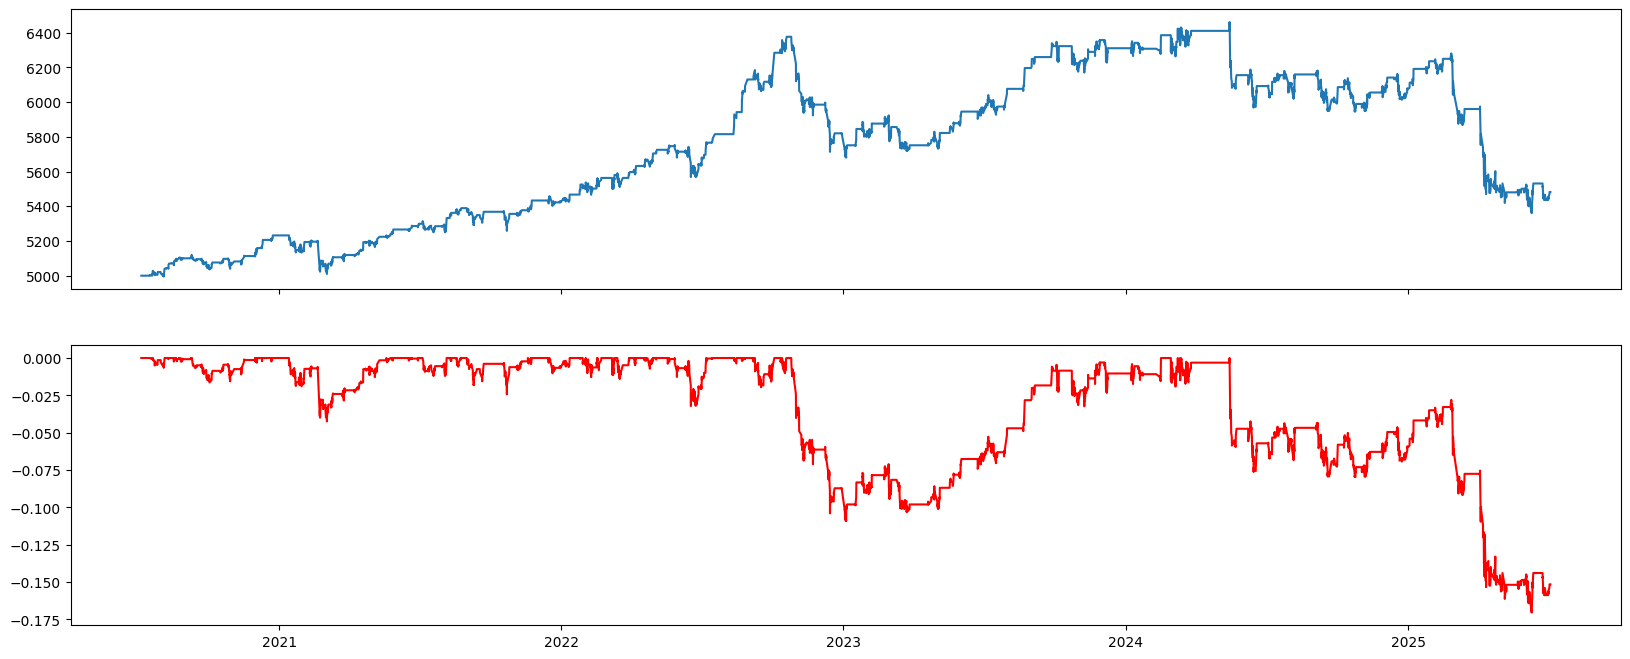

In [13]:
import matplotlib.pyplot as plt
initial_capital = 5000

df_trades['ret_cum'] = df_trades['ret'].cumsum()
df_trades['ret_cum'] += initial_capital

df_trades['max_cum'] = df_trades['ret_cum'].cummax()
df_trades['drawdown'] = df_trades['ret_cum'] / df_trades['max_cum'] -1

fig, ax = plt.subplots(2,1, sharex=True, figsize=(20,8))

ax[0].plot(df_trades['ret_cum'])
ax[1].plot(df_trades['drawdown'], color ='red')

### Underwater

In [14]:
df_trades['underwater'] = df_trades['ret_cum'] < df_trades['max_cum']

df_trades['underwater'].sum() * 5/60/8

df_trades

price kind  quantity  close  position  ret_market  ret  ret_cum  max_cum  drawdown  underwater
time                                                                                                               
2020-07-06 10:00:00    NaN  NaN       NaN   6.70       0.0         NaN  NaN      NaN      NaN       NaN       False
2020-07-06 11:00:00    NaN  NaN       NaN   6.65       0.0       -0.05 -0.0   5000.0   5000.0  0.000000       False
2020-07-06 12:00:00    NaN  NaN       NaN   6.58       0.0       -0.07 -0.0   5000.0   5000.0  0.000000       False
2020-07-06 13:00:00    NaN  NaN       NaN   6.61       0.0        0.03  0.0   5000.0   5000.0  0.000000       False
2020-07-06 14:00:00    NaN  NaN       NaN   6.62       0.0        0.01  0.0   5000.0   5000.0  0.000000       False
...                    ...  ...       ...    ...       ...         ...  ...      ...      ...       ...         ...
2025-07-03 12:00:00    NaN  NaN       NaN  32.24       0.0       -0.01 -0.0   5482.0   6461.0 -0.151525        True
2025-07-03 13:00:00    NaN  NaN       NaN  32.30       0.0        0.06  0.0   5482.0   6461.0 -0.151525        True
2025-07-03 14:00:00    NaN  NaN       NaN  32.25       0.0       -0.05 -0.0   5482.0   6461.0 -0.151525        True
2025-07-03 15:00:00    NaN  NaN       NaN  32.19       0.0       -0.06 -0.0   5482.0   6461.0 -0.151525        True
2025-07-03 16:00:00    NaN  NaN       NaN  32.16       0.0       -0.03 -0.0   5482.0   6461.0 -0.151525        True

[9161 rows x 11 columns]

### Indice de sharpe

O is1 é bom para comparar com variações dessa estratégia

In [15]:
is1 = df_trades['ret'].groupby(df_trades.index.date).sum().mean() / df_trades['ret'].groupby(df_trades.index.date).sum().std() 
is1

np.float64(0.014633430761166723)

In [16]:
is_selic = (df_trades['ret'].groupby(df_trades.index.date).sum().mean() - 0.15) / df_trades['ret'].groupby(df_trades.index.date).sum().std() 
is_selic

np.float64(0.008968289308814619)

## Otimização de parâmetros

**Overfitting:** é otimizar tanto ao ponto que a estratégia só funciona em um momento muito especifico

Para evitar: 

* In Sample -> 70% de treinamento e 30% de teste

In [17]:
# Parâmetros que podem ser otimizados
window = 14
up_exit = 70
down_entry = 30
dict_varr = []

for window in [14,21]:
    for up_exit in [50,60,70]:
        for down_entry in [20,30,40]:

            # Estratégia
            bet_size = 100
            df['rsi'] = get_rsi(window)
            list_trades = []
            t = 0
            for idx,row in df.iterrows():
                # se o rsi for menor que 30 e não tiver operações em aberto (t=0)
                if row['rsi'] <= down_entry and t == 0:
                    list_trades += [{'time': idx, 'price':row['close'], 'kind':'buy', 'quantity': bet_size}]
                    t = 1 # Agora está comprado/vendido
                
                # Se o rsi for maior que 70 e tiver operações em aberto (t+1)
                if row['rsi'] >= up_exit and t == 1:
                    list_trades += [{'time': idx, 'price':row['close'], 'kind':'sell', 'quantity': -bet_size}]
                    t = 0 # Agora não tem nenhuma operação

            df_raw = pd.DataFrame(list_trades)
            df_raw.set_index('time', inplace=True)
            df_trades = df_raw.join(df['close'], how='outer')
            df_trades['position'] = df_trades['quantity'].shift(1).fillna(0).cumsum()
            df_trades['ret_market'] = df_trades['close'] - df_trades['close'].shift(1)
            df_trades['ret'] = df_trades['ret_market'] * df_trades['position']
            df_trades['ret_cum'] = df_trades['ret'].cumsum()
            
            sharpe = df_trades['ret'].groupby(df_trades.index.date).sum().mean() / df_trades['ret'].groupby(df_trades.index.date).sum().std() 
            print(window, up_exit, down_entry, sharpe)
            dict_varr += [{'window':window, 'up_exit':up_exit, 'down_entry':down_entry, 'sharpe':sharpe}]

14 50 20 0.012249668723197714
14 50 30 -0.003560494209984276
14 50 40 0.03176838094997619
14 60 20 -0.00034974485665949733
14 60 30 0.002482892803695321
14 60 40 0.030091779788071774
14 70 20 -0.0011078094077621979
14 70 30 0.014633430761166723
14 70 40 0.030383280658422992
21 50 20 -0.008246449478761504
21 50 30 0.013113604326378205
21 50 40 0.023896044582610538
21 60 20 -0.0006799802156556758
21 60 30 0.016884699978373913
21 60 40 0.021681174197113094
21 70 20 0.0223345018480761
21 70 30 0.018660854957329737
21 70 40 0.010934867310686255


In [18]:
df_varr = pd.DataFrame(dict_varr)
df_varr

window  up_exit  down_entry    sharpe
0       14       50          20  0.012250
1       14       50          30 -0.003560
2       14       50          40  0.031768
3       14       60          20 -0.000350
4       14       60          30  0.002483
5       14       60          40  0.030092
6       14       70          20 -0.001108
7       14       70          30  0.014633
8       14       70          40  0.030383
9       21       50          20 -0.008246
10      21       50          30  0.013114
11      21       50          40  0.023896
12      21       60          20 -0.000680
13      21       60          30  0.016885
14      21       60          40  0.021681
15      21       70          20  0.022335
16      21       70          30  0.018661
17      21       70          40  0.010935

<Axes: xlabel='down_entry', ylabel='window'>

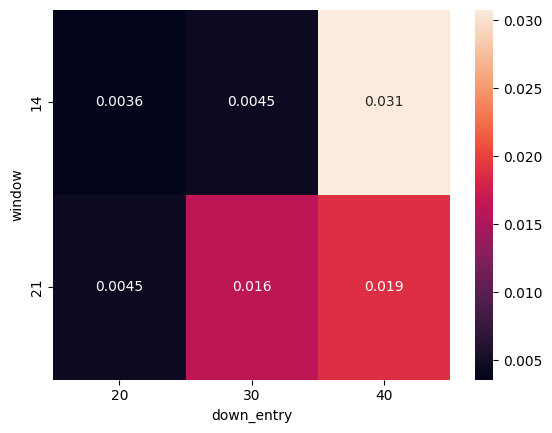

In [19]:
import seaborn as sns

sns.heatmap(df_varr.pivot_table(index='window', columns='down_entry', values='sharpe'),annot=True)

14 50 40 0.03176838094997619


<Axes: xlabel='time'>

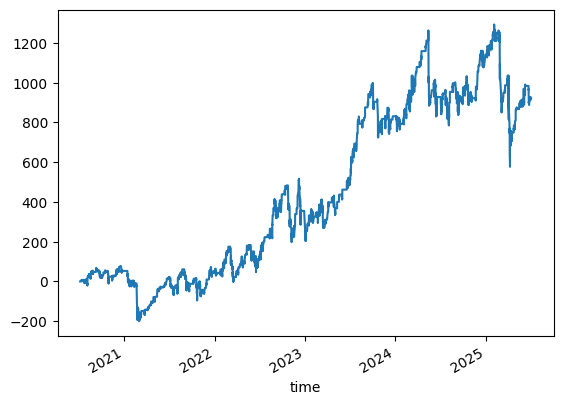

In [20]:
# Testando a estratégia que maximiza o sharpe

window = 14
up_exit = 50
down_entry = 40
bet_size = 100

df['rsi'] = get_rsi(window)

list_trades = []
t = 0

for idx,row in df.iterrows():
    # se o rsi for menor que 30 e não tiver operações em aberto (t=0)
    if row['rsi'] <= down_entry and t == 0:
        list_trades += [{'time': idx, 'price':row['close'], 'kind':'buy', 'quantity': bet_size}]
        t = 1 # Agora está comprado/vendido
    
    # Se o rsi for maior que 70 e tiver operações em aberto (t+1)
    if row['rsi'] >= up_exit and t == 1:
        list_trades += [{'time': idx, 'price':row['close'], 'kind':'sell', 'quantity': -bet_size}]
        t = 0 # Agora não tem nenhuma operação

df_raw = pd.DataFrame(list_trades)
df_raw.set_index('time', inplace=True)
df_trades = df_raw.join(df['close'], how='outer')
df_trades['position'] = df_trades['quantity'].shift(1).fillna(0).cumsum()
df_trades['ret_market'] = df_trades['close'] - df_trades['close'].shift(1)
df_trades['ret'] = df_trades['ret_market'] * df_trades['position']
df_trades['ret_cum'] = df_trades['ret'].cumsum()

sharpe = df_trades['ret'].groupby(df_trades.index.date).sum().mean() / df_trades['ret'].groupby(df_trades.index.date).sum().std() 
print(window, up_exit, down_entry, sharpe)

df_trades['ret_cum'].plot()
